# Privacy-Preserving Record Linkage (PPRL): Investigating Dataset Extension Attacks

## Setup

In [1]:
import os

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision

from utils import *

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import hickle as hkl
import numpy as np
import string
import sys
from tqdm.notebook import tqdm

from graphMatching.gma import run_gma

from datasets.bloom_filter_dataset import BloomFilterDataset
from datasets.tab_min_hash_dataset import TabMinHashDataset
from datasets.two_step_hash_dataset_padding import TwoStepHashDatasetPadding
from datasets.two_step_hash_dataset_frequency_string import TwoStepHashDatasetFrequencyString
from datasets.two_step_hash_dataset_one_hot_encoding import TwoStepHashDatasetOneHotEncoding

from pytorch_models.bloom_filter_to_two_gram_classifier import BloomFilterToTwoGramClassifier
from pytorch_models.tab_min_hash_to_two_gram_classifier import TabMinHashToTwoGramClassifier
from pytorch_models.two_step_hash_to_two_gram_classifier import TwoStepHashToTwoGramClassifier

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:20:01) [Clang 18.1.8 ]
PyTorch version 2.1.2
Torchvision version 0.16.2
Numpy version 1.24.4
Pandas version 2.0.3


## Run GMA

In [2]:
# Parameters
GLOBAL_CONFIG = {
    "Data": "./data/datasets/fakename_1k.tsv",
    "Overlap": 0.8,
    "DropFrom": "Both",
    "Verbose": True,  # Print Status Messages
    "MatchingMetric": "cosine",
    "Matching": "MinWeight",
    "Workers": -1,
    "SaveAliceEncs": False,
    "SaveEveEncs": False,
    "DevMode": True,
}


DEA_CONFIG = {
    #Padding / FrequencyString / OneHotEncoding
    "TSHMode": "OneHotEncoding",
    "DevMode": False,
    # BCEWithLogitsLoss / MultiLabelSoftMarginLoss
    "LossFunction:": "BCEWithLogitsLoss",
    # Adam / AdamW / SGD / RMSprop
    "Optimizer": "Adam",
    "LearningRate": 0.001,
    # SGD only
    "Momentum": 0.9,
    "BatchSize": 16,
    "Epochs": 10,
    # TestSize calculated accordingly
    "TrainSize": 0.8,
    "FilterThreshold": 0.5,
}

ENC_CONFIG = {
    # TwoStepHash / TabMinHash / BloomFilter
    "AliceAlgo": "BloomFilter",
    "AliceSecret": "SuperSecretSalt1337",
    "AliceN": 2,
    "AliceMetric": "dice",
    "EveAlgo": "None",
    "EveSecret": "ATotallyDifferentString42",
    "EveN": 2,
    "EveMetric": "dice",
    # For BF encoding
    "AliceBFLength": 1024,
    "AliceBits": 10,
    "AliceDiffuse": False,
    "AliceT": 10,
    "AliceEldLength": 1024,
    "EveBFLength": 1024,
    "EveBits": 10,
    "EveDiffuse": False,
    "EveT": 10,
    "EveEldLength": 1024,
    # For TMH encoding
    "AliceNHash": 1024,
    "AliceNHashBits": 64,
    "AliceNSubKeys": 8,
    "Alice1BitHash": True,
    "EveNHash": 1024,
    "EveNHashBits": 64,
    "EveNSubKeys": 8,
    "Eve1BitHash": True,
    # For 2SH encoding
    "AliceNHashFunc": 10,
    "AliceNHashCol": 1000,
    "AliceRandMode": "PNG",
    "EveNHashFunc": 10,
    "EveNHashCol": 1000,
    "EveRandMode": "PNG",
}

EMB_CONFIG = {
    "Algo": "Node2Vec",
    "AliceQuantile": 0.9,
    "AliceDiscretize": False,
    "AliceDim": 128,
    "AliceContext": 10,
    "AliceNegative": 1,
    "AliceNormalize": True,
    "EveQuantile": 0.9,
    "EveDiscretize": False,
    "EveDim": 128,
    "EveContext": 10,
    "EveNegative": 1,
    "EveNormalize": True,
    # For Node2Vec
    "AliceWalkLen": 100,
    "AliceNWalks": 20,
    "AliceP": 250,
    "AliceQ": 300,
    "AliceEpochs": 5,
    "AliceSeed": 42,
    "EveWalkLen": 100,
    "EveNWalks": 20,
    "EveP": 250,
    "EveQ": 300,
    "EveEpochs": 5,
    "EveSeed": 42
}

ALIGN_CONFIG = {
    "RegWS": max(0.1, GLOBAL_CONFIG["Overlap"]/2), #0005
    "RegInit":1, # For BF 0.25
    "Batchsize": 1, # 1 = 100%
    "LR": 200.0,
    "NIterWS": 100,
    "NIterInit": 5 ,  # 800
    "NEpochWS": 100,
    "LRDecay": 1,
    "Sqrt": True,
    "EarlyStopping": 10,
    "Selection": "None",
    "MaxLoad": None,
    "Wasserstein": True
}

In [3]:
eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash = get_hashes(GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG)

if(os.path.isfile("./data/available_to_eve/reidentified_individuals_%s_%s_%s_%s.h5" % (eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash)) & os.path.isfile("./data/available_to_eve/not_reidentified_individuals_%s_%s_%s_%s.h5" % (eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash))):
    #Load Disk From Data
    reidentified_individuals = hkl.load('./data/available_to_eve/reidentified_individuals_%s_%s_%s_%s.h5' % (eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash))
    df_reidentified_individuals = pd.DataFrame(reidentified_individuals[1:], columns=reidentified_individuals[0])

    not_reidentified_individuals = hkl.load('./data/available_to_eve/not_reidentified_individuals_%s_%s_%s_%s.h5' % (eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash))
    df_not_reidentified_individuals = pd.DataFrame(not_reidentified_individuals[1:], columns=not_reidentified_individuals[0])

    all_individuals = hkl.load('./data/dev/alice_data_complete_with_encoding_%s_%s_%s_%s.h5' % (eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash))
    df_all_individuals = pd.DataFrame(all_individuals[1:], columns=all_individuals[0])

else:
    reidentified_individuals, not_reidentified_individuals, all_individuals = run_gma(GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG, ALIGN_CONFIG, DEA_CONFIG, eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash)

    df_reidentified_individuals = pd.DataFrame(reidentified_individuals[1:], columns=reidentified_individuals[0])
    df_not_reidentified_individuals = pd.DataFrame(not_reidentified_individuals[1:], columns=not_reidentified_individuals[0])
    df_all_individuals = pd.DataFrame(all_individuals[1:], columns=all_individuals[0])

## Create Datasets 

In [4]:
#Create the 2-grams with dictionary

#Generate all 2-grams
alphabet = string.ascii_lowercase

# Generate all letter-letter 2-grams (aa-zz)
alphabet = string.ascii_lowercase
letter_letter_grams = [a + b for a in alphabet for b in alphabet]

# Generate all digit-digit 2-grams (00-99)
digits = string.digits
digit_digit_grams = [d1 + d2 for d1 in digits for d2 in digits]

# Generate all letter-digit 2-grams (a0-z9)
letter_digit_grams = [l + d for l in alphabet for d in digits]

# Combine all sets
all_two_grams = letter_letter_grams  + letter_digit_grams + digit_digit_grams

# Get a dictionary associating each 2-gram with an index
two_gram_dict = {i: two_gram for i, two_gram in enumerate(all_two_grams)}

In [5]:
# Create Datasets based on chosen encoding
if ENC_CONFIG["AliceAlgo"] == "BloomFilter":
    data_labeled = BloomFilterDataset(df_reidentified_individuals, is_labeled=True, all_two_grams=all_two_grams, dev_mode=GLOBAL_CONFIG["DevMode"])
    data_not_labeled = BloomFilterDataset(df_not_reidentified_individuals, is_labeled=False, all_two_grams=all_two_grams, dev_mode=GLOBAL_CONFIG["DevMode"])
    bloomfilter_length = len(df_reidentified_individuals["bloomfilter"][0])

if ENC_CONFIG["AliceAlgo"] == "TabMinHash":
    data_labeled = TabMinHashDataset(df_reidentified_individuals, is_labeled=True, all_two_grams=all_two_grams, dev_mode=GLOBAL_CONFIG["DevMode"])
    data_not_labeled = TabMinHashDataset(df_not_reidentified_individuals, is_labeled=False, all_two_grams=all_two_grams, dev_mode=GLOBAL_CONFIG["DevMode"])
    tabminhash_length = len(df_reidentified_individuals["tabminhash"][0])

if (ENC_CONFIG["AliceAlgo"] == "TwoStepHash") & (DEA_CONFIG["TSHMode"] == "Padding"):
    max_length_reidentified = df_reidentified_individuals["twostephash"].apply(lambda x: len(list(x))).max()
    max_length_not_reidentified = df_not_reidentified_individuals["twostephash"].apply(lambda x: len(list(x))).max()
    max_twostephash_length = max(max_length_reidentified, max_length_not_reidentified)
    data_labeled = TwoStepHashDatasetPadding(df_reidentified_individuals, is_labeled=True, all_two_grams=all_two_grams, max_set_size=max_twostephash_length, dev_mode=GLOBAL_CONFIG["DevMode"])
    data_not_labeled = TwoStepHashDatasetPadding(df_not_reidentified_individuals, is_labeled=False, all_two_grams=all_two_grams, max_set_size=max_twostephash_length, dev_mode=GLOBAL_CONFIG["DevMode"])

if (ENC_CONFIG["AliceAlgo"] == "TwoStepHash") & (DEA_CONFIG["TSHMode"] == "FrequencyString"):
    max_length_reidentified = df_reidentified_individuals["twostephash"].apply(lambda x: max(x)).max()
    max_length_not_reidentified = df_not_reidentified_individuals["twostephash"].apply(lambda x: max(x)).max()
    max_twostephash_length = max(max_length_reidentified, max_length_not_reidentified)
    data_labeled = TwoStepHashDatasetFrequencyString(df_reidentified_individuals, is_labeled=True, all_two_grams=all_two_grams, frequency_string_length=max_twostephash_length, dev_mode=GLOBAL_CONFIG["DevMode"])
    data_not_labeled = TwoStepHashDatasetFrequencyString(df_not_reidentified_individuals, is_labeled=False, all_two_grams=all_two_grams, frequency_string_length=max_twostephash_length, dev_mode=GLOBAL_CONFIG["DevMode"])

if (ENC_CONFIG["AliceAlgo"] == "TwoStepHash") & (DEA_CONFIG["TSHMode"] == "OneHotEncoding"):
    unique_integers_reidentified = set().union(*df_reidentified_individuals["twostephash"])
    unique_integers_not_reidentified = set().union(*df_not_reidentified_individuals["twostephash"])
    unique_integers_sorted = sorted(unique_integers_reidentified.union(unique_integers_not_reidentified))
    unique_integers_dict = {i: val for i, val in enumerate(unique_integers_sorted)}
    data_labeled = TwoStepHashDatasetOneHotEncoding(df_reidentified_individuals, is_labeled=True, all_integers=unique_integers_sorted, all_two_grams=all_two_grams, dev_mode=GLOBAL_CONFIG["DevMode"])
    data_not_labeled = TwoStepHashDatasetOneHotEncoding(df_not_reidentified_individuals, is_labeled=False, all_integers=unique_integers_sorted, all_two_grams=all_two_grams, dev_mode=GLOBAL_CONFIG["DevMode"])

## Create Dataloader

In [6]:
# Split proportions
train_size = int(DEA_CONFIG["TrainSize"] * len(data_labeled))
val_size = len(data_labeled) - train_size

#Split dataset of reidentified individuals
data_train, data_val = random_split(data_labeled, [train_size, val_size])

# Create dataloader
dataloader_train = DataLoader(data_train, batch_size=DEA_CONFIG["BatchSize"], shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=DEA_CONFIG["BatchSize"], shuffle=True)
dataloader_test = DataLoader(data_not_labeled, batch_size=DEA_CONFIG["BatchSize"], shuffle=False)

## Pytorch Model

In [7]:
# Create Models based on chosen encoding scheme
if ENC_CONFIG["AliceAlgo"] == "BloomFilter":
    model = BloomFilterToTwoGramClassifier(input_dim=bloomfilter_length, num_two_grams=len(all_two_grams))

if ENC_CONFIG["AliceAlgo"] == "TabMinHash":
    model = TabMinHashToTwoGramClassifier(input_dim=tabminhash_length, num_two_grams=len(all_two_grams))

if (ENC_CONFIG["AliceAlgo"] == "TwoStepHash") & (DEA_CONFIG["TSHMode"] == "Padding"):
    model = TwoStepHashToTwoGramClassifier(input_dim=max_twostephash_length, num_two_grams=len(all_two_grams))

if (ENC_CONFIG["AliceAlgo"] == "TwoStepHash") & (DEA_CONFIG["TSHMode"] == "FrequencyString"):
    model = TabMinHashToTwoGramClassifier(input_dim=max_twostephash_length, num_two_grams=len(all_two_grams))

if (ENC_CONFIG["AliceAlgo"] == "TwoStepHash") & (DEA_CONFIG["TSHMode"] == "OneHotEncoding"):
    model = TabMinHashToTwoGramClassifier(input_dim=len(unique_integers_sorted), num_two_grams=len(all_two_grams))


## Training Loop

In [8]:
#Setup Writer
experiment_name = DEA_CONFIG["LossFunction:"] + "_" + DEA_CONFIG["Optimizer"] + "_" + ENC_CONFIG["AliceAlgo"] + "_" + DEA_CONFIG["TSHMode"]
writer = SummaryWriter("runs/%s" % experiment_name)

In [9]:
# Define Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

BloomFilterToTwoGramClassifier(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=256, out_features=1036, bias=True)
  )
)

In [10]:
# Loss function for multi-label classification
if(DEA_CONFIG["LossFunction:"] == "BCEWithLogitsLoss"):
    criterion = nn.BCEWithLogitsLoss()
if(DEA_CONFIG["LossFunction:"] == "MultiLabelSoftMarginLoss"):
    criterion = nn.MultiLabelSoftMarginLoss()

In [11]:
# Optimizer
if(DEA_CONFIG["Optimizer"] == "Adam"):
    optimizer = optim.Adam(model.parameters(), lr=DEA_CONFIG["LearningRate"])
if(DEA_CONFIG["Optimizer"] == "AdamW"):
    optimizer = optim.AdamW(model.parameters(), lr=DEA_CONFIG["LearningRate"])
if(DEA_CONFIG["Optimizer"] == "SGD"):
    optimizer = optim.SGD(model.parameters(), lr=DEA_CONFIG["LearningRate"], momentum=DEA_CONFIG["Momentum"])
if(DEA_CONFIG["Optimizer"] == "RMSprop"):
    optimizer = optim.RMSprop(model.parameters(), lr=DEA_CONFIG["LearningRate"])

In [12]:
train_losses, val_losses = [], []

for epoch in range(DEA_CONFIG["Epochs"]):
    # Training
    model.train()
    running_loss = 0.0
    for data, labels, _ in tqdm(dataloader_train, desc="Training loop"):
        # Move data to device
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(dataloader_train.dataset)
    train_losses.append(train_loss)
    writer.add_scalar("Loss/train", train_loss, epoch + 1)

    #Calculate true training loss?

    #Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data, labels, _ in tqdm(dataloader_val, desc="Validation loop"):
            # Move data to device
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
        val_loss = running_loss / len(dataloader_val.dataset)
        val_losses.append(val_loss)
        writer.add_scalar("Loss/validation", val_loss, epoch + 1)
    print(f"Epoch {epoch + 1}/{DEA_CONFIG['Epochs']} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

writer.flush()
writer.close()

Training loop:   0%|          | 0/1 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/10 - Train loss: 0.6943, Validation loss: 0.6906


Training loop:   0%|          | 0/1 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/10 - Train loss: 0.6907, Validation loss: 0.6856


Training loop:   0%|          | 0/1 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/10 - Train loss: 0.6849, Validation loss: 0.6767


Training loop:   0%|          | 0/1 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/10 - Train loss: 0.6734, Validation loss: 0.6592


Training loop:   0%|          | 0/1 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/10 - Train loss: 0.6544, Validation loss: 0.6260


Training loop:   0%|          | 0/1 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/10 - Train loss: 0.6081, Validation loss: 0.5678


Training loop:   0%|          | 0/1 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/10 - Train loss: 0.5470, Validation loss: 0.4738


Training loop:   0%|          | 0/1 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/10 - Train loss: 0.4322, Validation loss: 0.3438


Training loop:   0%|          | 0/1 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/10 - Train loss: 0.3077, Validation loss: 0.2072


Training loop:   0%|          | 0/1 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/10 - Train loss: 0.1840, Validation loss: 0.1195


## Visualize Losses and Performance Metrics

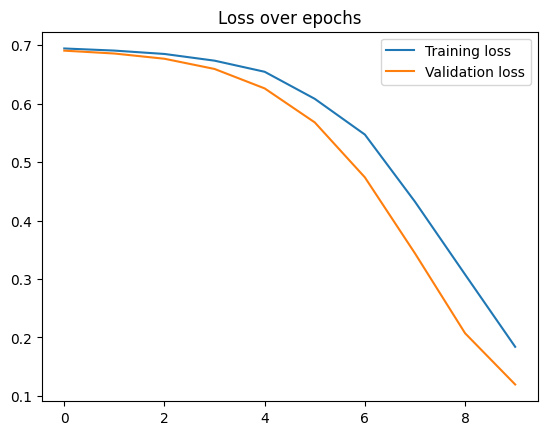

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Re-Identify Not-Reidentified Individuals

### Apply Model to Not-Reiditentified Individuals

In [16]:
# List to store decoded 2-gram scores for all test samples
decoded_test_results_words = []
combined_results_performance = []

# Switch to evaluation mode
model.eval()

# Define Threshhold
threshold = DEA_CONFIG["FilterThreshold"]

# Loop through the test dataloader
with torch.no_grad():  # No need to compute gradients during inference
    for data_batch, uids in tqdm(dataloader_test, desc="Test loop"):
        # Filter relevant individuals from df_all_individuals
        filtered_df = df_all_individuals[df_all_individuals["uid"].isin(uids)].drop(df_all_individuals.columns[-2], axis=1) # Drop encoding column

        actual_two_grams_batch = []
        for _, entry in filtered_df.iterrows():
            row = entry[:-1] # Exclude UID
            extracted_two_grams = extract_two_grams("".join(map(str, row)))
            actual_two_grams_batch.append({"uid": entry["uid"], "two_grams": extracted_two_grams})

        # Move data to device
        data_batch = data_batch.to(device)

        # Apply model
        logits = model(data_batch)

        # Convert logits to probabilities using sigmoid (for binary classification)
        probabilities = torch.sigmoid(logits)

        # Convert probabilities into 2-gram scores (use two_gram_dict as before)
        batch_two_gram_scores = [
            {two_gram_dict[j]: score.item() for j, score in enumerate(probabilities[i])} #2: For each sample, go through all predicted probabilities (scores)
            for i in range(probabilities.size(0))  # 1: Iterate over each sample in the batch
        ]

        # Apply threshold to filter 2-gram scores (values above threshold are kept)
        batch_filtered_two_gram_scores = [
            {two_gram: score for two_gram, score in two_gram_scores.items() if score > threshold}
            for two_gram_scores in batch_two_gram_scores
        ]

        filtered_two_grams = [
        {"uid": uid, "two_grams": {key for key in two_grams.keys()}}
        for uid, two_grams in zip(uids, batch_filtered_two_gram_scores)
        ]

        # Reconstruct words for each sample in the batch
        batch_reconstructed_words = [
            reconstruct_words(filtered_scores) for filtered_scores in batch_filtered_two_gram_scores
        ]

        # Append the results for this batch
        decoded_test_results_words.extend(batch_reconstructed_words)

        for entry_two_grams_batch in actual_two_grams_batch:  # Loop through each uid in the batch
            for entry_filtered_two_grams in filtered_two_grams:
                if entry_two_grams_batch["uid"] == entry_filtered_two_grams["uid"]:
                    combined_results_performance.append({
                    "uid": entry_two_grams_batch["uid"],
                    "actual_two_grams": entry_two_grams_batch["two_grams"],  # Get the two_grams for the current uid
                    "predicted_two_grams": entry_filtered_two_grams["two_grams"],  # Get the predicted two_grams
                    "dice_similarity":  dice_coefficient(entry_two_grams_batch["two_grams"], entry_filtered_two_grams["two_grams"]),
                    })


# Now `decoded_test_results` contains the reconstructed words for all test samples
# print("Decoded Test Results: ", decoded_test_results)
print(combined_results_performance)


Test loop:   0%|          | 0/52 [00:00<?, ?it/s]

[{'uid': '15576', 'actual_two_grams': ['ca', 'al', 'le', 'eb', 'bb', 'be', 'ee', 'em', 'm1', '11', '12', '28', '81', '19', '94', '40'], 'predicted_two_grams': {'51', 'tk', '19'}, 'dice_similarity': 0.1053}, {'uid': '62930', 'actual_two_grams': ['su', 'us', 'sa', 'an', 'ns', 'st', 'tr', 'ri', 'ic', 'ck', 'kl', 'la', 'an', 'nd', 'd1', '11', '12', '23', '31', '19', '98', '83'], 'predicted_two_grams': {'51', 'tk', '19'}, 'dice_similarity': 0.0833}, {'uid': '55125', 'actual_two_grams': ['yv', 'vo', 'on', 'nn', 'ne', 'ed', 'di', 'il', 'll', 'la', 'ar', 'rd', 'd5', '57', '71', '19', '99', '99'], 'predicted_two_grams': {'51', 'tk', '19'}, 'dice_similarity': 0.1}, {'uid': '68304', 'actual_two_grams': ['ca', 'ar', 'rm', 'me', 'en', 'nj', 'ja', 'am', 'me', 'es', 's6', '61', '13', '31', '19', '97', '70'], 'predicted_two_grams': {'51', 'tk', '19'}, 'dice_similarity': 0.1053}, {'uid': '76831', 'actual_two_grams': ['co', 'or', 'ri', 'in', 'nn', 'ne', 'eg', 'gr', 'ro', 'ov', 've', 'es', 's3', '33', '3

## Visualize Performance for Re-Identification

In [15]:
sys.exit("Stopping execution at this cell.")

SystemExit: Stopping execution at this cell.

/Users/I538952/Desktop/master/4-semester-thesis/dataset-extension-attack/.conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Testing Area

In [ ]:
print('Reidentified Individuals:')
print(df_reidentified_individuals.head())
print('Not Reidentified Individuals:')
print(df_not_reidentified_individuals.head())

In [ ]:
data_labeled.labelTensors[1]

In [ ]:
for data, labels in dataloader_train:
    data, labels = data.to(device), labels.to(device)
    print(data.shape)
    print(labels.shape)
    break

In [ ]:
print("To Decode: ",df_not_reidentified_individuals.iloc[1])
torch.set_printoptions(profile="full")
#torch.set_printoptions(profile="default")
print("Tensor: ", data_not_labeled[1])
# Apply model
model.eval()
logits = model(data_not_labeled[1])
probabilities = torch.sigmoid(logits)
print("Prob: ", probabilities)
two_gram_scores = {two_gram_dict[i]: score.item() for i, score in enumerate(probabilities)}
threshold = 0.5
filtered_two_gram_scores = {two_gram: score for two_gram, score in two_gram_scores.items() if score > threshold}
print("Decoded 2grams: ", filtered_two_gram_scores)

print(reconstruct_words(filtered_two_gram_scores))

# person is: Ray Haywood 9/27/1959
# ra -

In [ ]:
model = nn.Linear(20, 5) # predict logits for 5 classes
x = torch.randn(1, 20)
print(x.shape)
y = torch.tensor([[1., 0., 1., 0., 0.]]) # get classA and classC as active
print(y.shape)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

for epoch in range(20):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    print('Loss: {:.3f}'.format(loss.item()))